<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [85]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [86]:
from google.colab import drive

drive.mount('/content/drive')
'''
!tar -xvf drive/MyDrive/cable.tar.gz cable
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\n!tar -xvf drive/MyDrive/cable.tar.gz cable\n'

In [87]:
file_paths = glob.glob('/content/drive/MyDrive/HW03Rawdata/hazelnut/train/good/*.png')
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

In [88]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 1024, 1024, 3)


In [89]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[-1] for path in file_paths]))
print(f'Classes: {classes}')

#images_per_class = len(all_data) // len(classes)
images_per_class = 1
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(min(2, len(all_data) - index)):
    #for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## A. Data Loading and Preprocessing

In [90]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 8
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (8, 3, 1024, 1024)
Shape of x_val: (2, 3, 1024, 1024)
Shape of y_train: (64,)
Shape of y_val: (16,)


In [91]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [92]:
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [93]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 8

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## C. Training the Neural Network

In [94]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 2.7528, Train acc: 0.0000%, Val loss: 1.6478, Val acc: 100.0000%, Best Val loss: 1.6478 Best Val acc: 100.00%
Epoch 2/100, Train loss: 1.8672, Train acc: 25.0000%, Val loss: 1.5988, Val acc: 100.0000%, Best Val loss: 1.5988 Best Val acc: 100.00%
Epoch 3/100, Train loss: 1.1646, Train acc: 75.0000%, Val loss: 1.5306, Val acc: 100.0000%, Best Val loss: 1.5306 Best Val acc: 100.00%
Epoch 4/100, Train loss: 0.7062, Train acc: 100.0000%, Val loss: 1.4091, Val acc: 100.0000%, Best Val loss: 1.4091 Best Val acc: 100.00%
Epoch 5/100, Train loss: 0.3201, Train acc: 100.0000%, Val loss: 1.2552, Val acc: 100.0000%, Best Val loss: 1.2552 Best Val acc: 100.00%
Epoch 6/100, Train loss: 0.2788, Train acc: 100.0000%, Val loss: 1.0026, Val acc: 100.0000%, Best Val loss: 1.0026 Best Val acc: 100.00%
Epoch 7/100, Train loss: 0.1573, Train acc: 100.0000%, Val loss: 0.7351, Val acc: 100.0000%, Best Val loss: 0.7351 Best Val acc: 100.00%
Epoch 8/100, Train loss: 0.0985, Train acc: 1

### Visualizing model performance

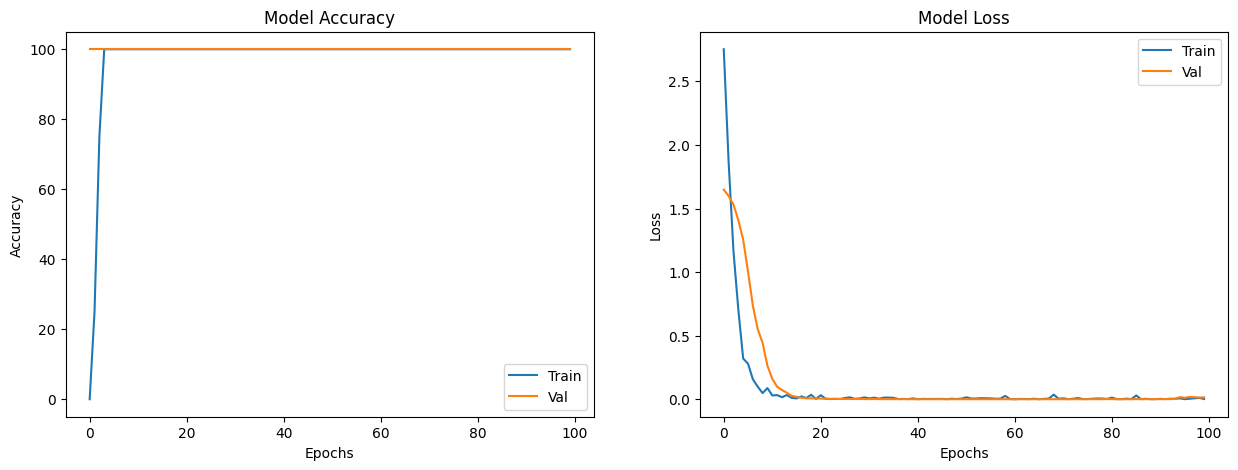

In [95]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [96]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0], device='cuda:0')
tensor([0, 0], device='cuda:0')
Test accuracy is 100.0%


In [97]:
pip install torch torchvision scikit-learn opencv-python matplotlib tqdm

In [98]:
# Data Loading and Preprocessing
import os

import glob

from PIL import Image

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader



class MVTECDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*.png")))

        self.transform = transform



    def __len__(self):

        return len(self.image_paths)



    def __getitem__(self, idx):

        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:

            img = self.transform(img)

        return img



transform = transforms.Compose([

    transforms.Resize((256, 256)),

    transforms.ToTensor()

])

# Baseline Autoencoder
import os

import glob

from PIL import Image

from torchvision import transforms

from torch.utils.data import Dataset, DataLoader



class MVTECDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "*.png")))

        self.transform = transform



    def __len__(self):

        return len(self.image_paths)



    def __getitem__(self, idx):

        img = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:

            img = self.transform(img)

        return img



transform = transforms.Compose([

    transforms.Resize((256, 256)),

    transforms.ToTensor()

])

# file_paths = glob.glob('/content/drive/MyDrive/HW03Rawdata/hazelnut/train/good/*.png')

train_dataset = MVTECDataset("/content/drive/MyDrive/HW03Rawdata/hazelnut/train/good", transform=transform) # Path corrected

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



In [99]:
#Baseline Autoencoder
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 128x128
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),  # 64x64
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, 2, 1),  # 32x32
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 128x128
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),  # 256x256
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = AutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training Loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for imgs in train_loader:
        imgs = imgs.cuda()
        output = model(imgs)
        loss = criterion(output, imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/50], Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/50], Loss: 0.1076
Epoch [2/50], Loss: 0.0396
Epoch [3/50], Loss: 0.0165
Epoch [4/50], Loss: 0.0072
Epoch [5/50], Loss: 0.0057
Epoch [6/50], Loss: 0.0036
Epoch [7/50], Loss: 0.0021
Epoch [8/50], Loss: 0.0012
Epoch [9/50], Loss: 0.0009
Epoch [10/50], Loss: 0.0007
Epoch [11/50], Loss: 0.0006
Epoch [12/50], Loss: 0.0005
Epoch [13/50], Loss: 0.0005
Epoch [14/50], Loss: 0.0005
Epoch [15/50], Loss: 0.0004
Epoch [16/50], Loss: 0.0004
Epoch [17/50], Loss: 0.0004
Epoch [18/50], Loss: 0.0004
Epoch [19/50], Loss: 0.0003
Epoch [20/50], Loss: 0.0003
Epoch [21/50], Loss: 0.0003
Epoch [22/50], Loss: 0.0003
Epoch [23/50], Loss: 0.0003
Epoch [24/50], Loss: 0.0003
Epoch [25/50], Loss: 0.0003
Epoch [26/50], Loss: 0.0003
Epoch [27/50], Loss: 0.0003
Epoch [28/50], Loss: 0.0003
Epoch [29/50], Loss: 0.0003
Epoch [30/50], Loss: 0.0003
Epoch [31/50], Loss: 0.0002
Epoch [32/50], Loss: 0.0002
Epoch [33/50], Loss: 0.0002
Epoch [34/50], Loss: 0.0002
Epoch [35/50], Loss: 0.0002
Epoch [36/50], Loss: 0.0002
E

In [100]:
#加入 CutPaste 增強（簡化版）
import random
from torchvision.transforms import functional as F

def cutpaste_transform(img):
    w, h = img.size
    patch_size = (random.randint(20, 40), random.randint(20, 40))
    src_x, src_y = random.randint(0, w - patch_size[0]), random.randint(0, h - patch_size[1])
    dst_x, dst_y = random.randint(0, w - patch_size[0]), random.randint(0, h - patch_size[1])
    patch = img.crop((src_x, src_y, src_x + patch_size[0], src_y + patch_size[1]))
    img.paste(patch, (dst_x, dst_y))
    return img

# 加入到 transform 中
cutpaste_transform_compose = transforms.Compose([
    transforms.Lambda(cutpaste_transform),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [101]:
#使用 SSIM Loss（需安裝）
!pip install pytorch-msssim

In [102]:
from pytorch_msssim import ssim

# 替代 MSE 損失
def ssim_loss(pred, target):
    return 1 - ssim(pred, target, data_range=1.0, size_average=True)

In [103]:
#測試階段與重建誤差計算

import numpy as np

from sklearn.metrics import roc_auc_score



# 測試資料夾路徑範例（包含 good + defect）

test_dir = "/content/drive/MyDrive/HW03Rawdata/hazelnut/test"

subdirs = os.listdir(test_dir)

#test_dataset = MVTECDataset("/content/drive/MyDrive/HW03Rawdata/hazelnut/test", transform=transform) # Path corrected

test_images = []

labels = []  # 0 for good, 1 for anomaly



for sub in subdirs:

    image_paths = sorted(glob.glob(os.path.join(test_dir, sub, "*.png")))

    for path in image_paths:

        img = Image.open(path).convert("RGB")

        img = transform(img)

        test_images.append(img)

        labels.append(0 if sub == "good" else 1)



test_images = torch.stack(test_images)

test_loader = DataLoader(test_images, batch_size=1, shuffle=False)


labels = np.array(labels)

In [104]:

#計算重建誤差並評估 AUC
model.eval()
recon_errors = []

with torch.no_grad():
    for img in test_loader:
        img = img.cuda()
        output = model(img)
        mse = torch.mean((output - img) ** 2, dim=[1, 2, 3])
        recon_errors.extend(mse.cpu().numpy())

recon_errors = np.array(recon_errors)
auc = roc_auc_score(labels, recon_errors)
print(f"AUC score: {auc:.4f}")

AUC score: 0.8929


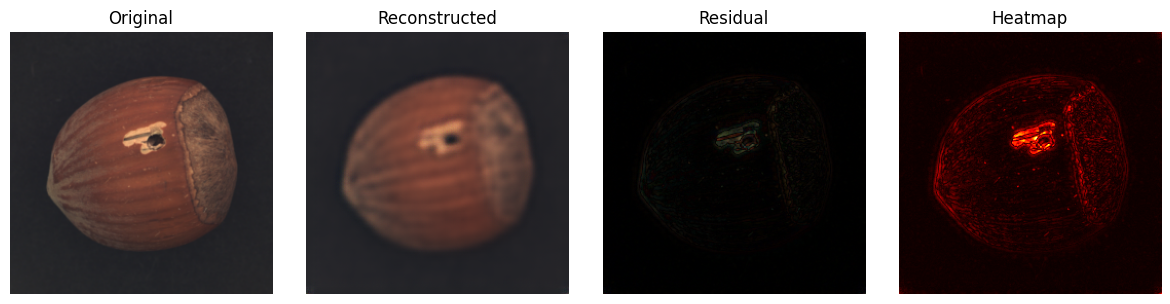

In [105]:
#可視化差異圖（Residual Map）與 Heatmap

import matplotlib.pyplot as plt

def show_diff(img, recon, idx=0):
    img_np = img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    recon_np = recon.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Detach before converting
    diff = np.abs(img_np - recon_np)
    heatmap = np.mean(diff, axis=2)

    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    ax[0].imshow(img_np)
    ax[0].set_title("Original")
    ax[1].imshow(recon_np)
    ax[1].set_title("Reconstructed")
    ax[2].imshow(diff)
    ax[2].set_title("Residual")
    ax[3].imshow(heatmap, cmap='hot')
    ax[3].set_title("Heatmap")
    for a in ax:
        a.axis('off')
    plt.tight_layout()
    plt.show()

# 可視化第 idx 張
sample_img = test_images[labels == 1][0].unsqueeze(0).cuda()
recon = model(sample_img)
show_diff(sample_img, recon)

In [106]:
import os
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Correct paths for the train and test directories
train_dir = "/content/drive/MyDrive/HW03Rawdata/hazelnut/train/good"  # Train directory
test_dir = "/content/drive/MyDrive/HW03Rawdata/hazelnut/test"        # Test directory containing subfolders good, hole, print

# Paths with wildcard for image files in each subfolder (good, hole, print)
train_path = os.path.join(train_dir, "*.png")
test_good_path = os.path.join(test_dir, "good", "*.png")
test_hole_path = os.path.join(test_dir, "hole", "*.png")
test_print_path = os.path.join(test_dir, "print", "*.png")

# Verify the directories exist (without wildcard)
print("Train 資料夾存在？", os.path.isdir(train_dir))  # Check if the train directory exists
print("Test 資料夾存在？", os.path.isdir(test_dir))  # Check if the test directory exists
print("Test (good) 圖片數量：", len(glob.glob(test_good_path)))  # Check number of good images
print("Test (hole) 圖片數量：", len(glob.glob(test_hole_path)))  # Check number of hole images
print("Test (print) 圖片數量：", len(glob.glob(test_print_path)))  # Check number of print images
print("Train 圖片數量：", len(glob.glob(train_path)))  # Check the number of train images

Train 資料夾存在？ True
Test 資料夾存在？ True
Test (good) 圖片數量： 40
Test (hole) 圖片數量： 18
Test (print) 圖片數量： 17
Train 圖片數量： 391


訓練資料（good）總數：391 張

測試資料分布：
 - crack: 18 張
 - cut: 17 張
 - good: 40 張
 - hole: 18 張
 - print: 17 張

總圖像數量：501 張
 - 訓練資料總數：391 張
 - 測試資料總數：110 張

缺陷類別總數：4 類
缺陷類別：['crack', 'cut', 'hole', 'print']

圖片尺寸樣本（前幾張）：{(1024, 1024)}
Image sizes list type: <class 'list'>


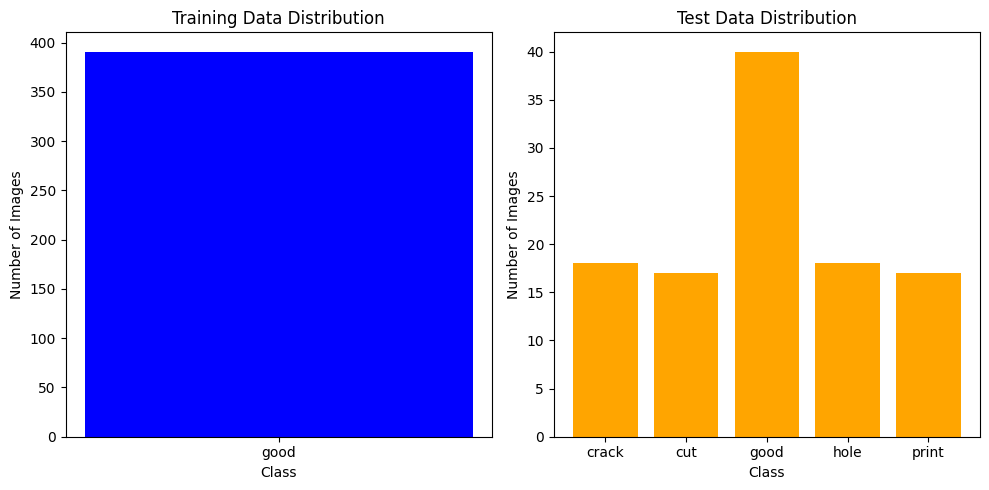

In [107]:
import os
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt  # Import matplotlib for plotting
from PIL import Image

# Specify the path for the hazelnut dataset (adjust according to your Google Drive)
base_path = "/content/drive/MyDrive/HW03Rawdata/hazelnut/"

# --- 1. Count Images in Training Dataset ---
train_good_path = os.path.join(base_path, "train", "good")
train_imgs = glob(os.path.join(train_good_path, "*.png"))

# Print number of images in the training dataset
print(f"訓練資料（good）總數：{len(train_imgs)} 張")

# --- 2. Count Images in Test Dataset ---
test_dir = os.path.join(base_path, "test")

# Get the list of defect classes (good, hole, print, etc.)
defect_classes = sorted(os.listdir(test_dir))

# Dictionary to store the count of images in each defect class
test_summary = defaultdict(int)

# Iterate over each defect class and count the images
for defect in defect_classes:
    defect_path = os.path.join(test_dir, defect)
    image_paths = glob(os.path.join(defect_path, "*.png"))

    # Record the number of images in each defect category
    test_summary[defect] = len(image_paths)

# Print out the number of images in the test dataset by defect class
print("\n測試資料分布：")
for k, v in test_summary.items():
    print(f" - {k}: {v} 張")

# --- 3. Total Number of Images Used in the Dataset ---
total_train_images = len(train_imgs)
total_test_images = sum(test_summary.values())

# Total number of images in both datasets
total_images = total_train_images + total_test_images
print(f"\n總圖像數量：{total_images} 張")
print(f" - 訓練資料總數：{total_train_images} 張")
print(f" - 測試資料總數：{total_test_images} 張")

# Count defect classes (excluding "good")
defect_only = [d for d in defect_classes if d != "good"]
print(f"\n缺陷類別總數：{len(defect_only)} 類")
print(f"缺陷類別：{defect_only}")


# Analyze image sizes (first few unique sizes)
image_sizes = []
for img_path in train_imgs:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

# Find unique image sizes
unique_sizes = set(image_sizes)
print(f"\n圖片尺寸樣本（前幾張）：{unique_sizes}")

# Data type checks for image_sizes list
print(f"Image sizes list type: {type(image_sizes)}")  # Should be a list of tuples (width, height)

# --- 4. Distribution of Training and Test Data ---
# Now we will plot the distribution using a bar chart

# Data for plotting (we only have 'good' for training, and defect classes for testing)
train_data = {'good': total_train_images}  # training set has only 'good' images
test_data = test_summary  # This dictionary already has the defect distribution

# Plotting the training and test data distribution
plt.figure(figsize=(10, 5))

# Plot Training Data
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, 1st plot)
plt.bar(train_data.keys(), train_data.values(), color='blue')
plt.title('Training Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Plot Test Data
plt.subplot(1, 2, 2)  # 2nd plot
plt.bar(test_data.keys(), test_data.values(), color='orange')
plt.title('Test Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# Display the plots
plt.tight_layout()
plt.show()

In [108]:
for imgs in train_loader:
    imgs = imgs.cuda()
    output = model(imgs)
    loss = criterion(output, imgs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

    # 釋放內存
    torch.cuda.empty_cache()

print(f"Epoch [{epoch+1}/50], Loss: {total_loss/len(train_loader):.4f}")

Epoch [50/50], Loss: 0.0004
